# Wasserstein GAN (WGAN)

# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
import glob
import imageio
from IPython import display
import cv2
import pathlib
import zipfile
import torch
import sys
import pandas as pd 

import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import MNIST

from skimage import io, transform

from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

# Device Mode

In [3]:
# Decide which device we want to run on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Generator

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            
            self.get_generator_block(z_dim, 
                                     hidden_dim * 4,
                                     kernel_size=3, 
                                     stride=2),
            
            self.get_generator_block(hidden_dim * 4, 
                                     hidden_dim * 2,
                                     kernel_size=4,
                                     stride = 1),
            
            self.get_generator_block(hidden_dim * 2,
                                     hidden_dim ,
                                     kernel_size=3,
                                     stride = 2,
                                    ),

            self.get_generator_final_block(hidden_dim,
                                           im_chan,
                                           kernel_size=4,
                                           stride=2)
            

        )
        
        
    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True),
        )
    
    
    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )
    
    
    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)
    
    
    
summary(Generator(100).to(device), (100,))
print(Generator(100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         230,656
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 830,785
Trainable params: 830,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# Critic / Discriminator

In [5]:
class Critic(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            self.get_critic_block(im_chan,
                                         hidden_dim * 4,
                                         kernel_size=4,
                                         stride=2),
            
            self.get_critic_block(hidden_dim * 4,
                                         hidden_dim * 8,
                                         kernel_size=4,
                                         stride=2,),
            
            self.get_critic_final_block(hidden_dim * 8,
                                               1,
                                               kernel_size=4,
                                               stride=2,),

        )

        
    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
        )
    
    
    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )
    
    def forward(self, image):
        return self.disc(image)
    
summary(Critic().to(device) , (1,28,28))
print(Critic())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]           1,088
       BatchNorm2d-2           [-1, 64, 13, 13]             128
         LeakyReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 5, 5]         131,200
       BatchNorm2d-5            [-1, 128, 5, 5]             256
         LeakyReLU-6            [-1, 128, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           2,049
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.51
Estimated Total Size (MB): 0.84
----------------------------------------------------------------
Critic(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2,

# Noise Creator Function

In [6]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

# MNIST Dataset Load

In [7]:
z_dim = 100
batch_size = 128

fixed_noise = get_noise(batch_size, z_dim, device=device)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

# Loaded Data Visualization

Time is 0.0246126651763916 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


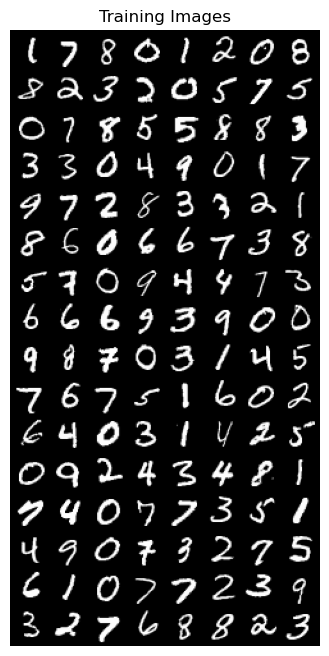

In [8]:
start = time.time()
dataiter = iter(dataloader)
images,labels = dataiter._next_data()
print ('Time is {} sec'.format(time.time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

# Optimizer

In [9]:
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

crit  = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)        

In [10]:
# test = get_noise(batch_size, z_dim, device=device)
# test_gan = gen(test)
# grid_img = np.transpose(make_grid(test_gan[0].to(device), padding=2, normalize=True).cpu().detach(),(1,2,0))

# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(grid_img)

# Gradient Penalty

In [11]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)
    
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

# Loss

In [12]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [13]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

# Model Training Process

In [14]:
def get_gradient(crit, real, fake, epsilon):

    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)
    
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
        
    )[0]
    return gradient

In [15]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show_fig:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        
    plt.show()

In [16]:
def train_gan(crit, gen, dataloader):
    n_epochs = 5
    cur_step = 0
    total_steps = 0
    start_time = time.time()
    cur_step = 0

    generator_losses = []
    critic_losses = []

    C_mean_losses = []
    G_mean_losses = []

    c_lambda = 10
    crit_repeats = 5
    display_step = 50

    for epoch in range(n_epochs):
        cur_step = 0
        start = time.time()
        for real, _ in dataloader:
            cur_batch_size = len(real)
            real = real.to(device)

            mean_iteration_critic_loss = 0
            for _ in range(crit_repeats):
                ### Update critic ###
                crit_opt.zero_grad()
                fake_noise = get_noise(cur_batch_size, z_dim, device=device)
                fake = gen(fake_noise)
                crit_fake_pred = crit(fake.detach())
                crit_real_pred = crit(real)

                epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
                gradient = get_gradient(crit, real, fake.detach(), epsilon)
                gp = gradient_penalty(gradient)
                crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

                # Keep track of the average critic loss in this batch
                mean_iteration_critic_loss += crit_loss.item() / crit_repeats
                # Update gradients
                crit_loss.backward(retain_graph=True)
                # Update optimizer
                crit_opt.step()
            critic_losses += [mean_iteration_critic_loss]

            ### Update generator ###
            gen_opt.zero_grad()
            fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
            fake_2 = gen(fake_noise_2)
            crit_fake_pred = crit(fake_2)

            gen_loss = get_gen_loss(crit_fake_pred)
            gen_loss.backward()

            # Update the weights
            gen_opt.step()

            # Keep track of the average generator loss
            generator_losses += [gen_loss.item()]

            cur_step += 1
            total_steps += 1

            print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader)}\t"
            print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
            print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
            print_val += f"Loss_G : {gen_loss:.6f}\t"  
            print(print_val, end='\r',flush = True)

            ### Visualization code ###
    #         if cur_step % display_step == 0 and cur_step > 0:
    #             print()
    #             gen_mean = sum(generator_losses[-display_step:]) / display_step
    #             crit_mean = sum(critic_losses[-display_step:]) / display_step
    #             print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
    #             show_tensor_images(fake)
    #             show_tensor_images(real)
    #             step_bins = 20
    #             num_examples = (len(generator_losses) // step_bins) * step_bins
    #             plt.plot(
    #                 range(num_examples // step_bins), 
    #                 torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
    #                 label="Generator Loss"
    #             )
    #             plt.plot(
    #                 range(num_examples // step_bins), 
    #                 torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
    #                 label="Critic Loss"
    #             )
    #             plt.legend()
    #             plt.show()

        print()
        gen_mean = sum(generator_losses[-cur_step:]) / cur_step
        crit_mean = sum(critic_losses[-cur_step:]) / cur_step

        C_mean_losses.append(crit_mean)
        G_mean_losses.append(gen_mean)

        print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
        print_val += f"Total_Time : {(time.time() - start_time):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"
        print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
        print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
        print(print_val)

        fake_noise = fixed_noise
        fake = gen(fake_noise)

        show_tensor_images(fake, show_fig=True,epoch=epoch)

        cur_step = 0

In [17]:
n_epochs = 1
cur_step = 0
total_steps = 0
start_time = time.time()
cur_step = 0

generator_losses = []
critic_losses = []

C_mean_losses = []
G_mean_losses = []

c_lambda = 10
crit_repeats = 5
display_step = 50

for epoch in range(n_epochs):
    cur_step = 0
    start = time.time()
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        
        cur_step += 1
        total_steps += 1
        
        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader)}\t"
        print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"  
        print(print_val, end='\r',flush = True)

        ### Visualization code ###
#         if cur_step % display_step == 0 and cur_step > 0:
#             print()
#             gen_mean = sum(generator_losses[-display_step:]) / display_step
#             crit_mean = sum(critic_losses[-display_step:]) / display_step
#             print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
#             show_tensor_images(fake)
#             show_tensor_images(real)
#             step_bins = 20
#             num_examples = (len(generator_losses) // step_bins) * step_bins
#             plt.plot(
#                 range(num_examples // step_bins), 
#                 torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
#                 label="Generator Loss"
#             )
#             plt.plot(
#                 range(num_examples // step_bins), 
#                 torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
#                 label="Critic Loss"
#             )
#             plt.legend()
#             plt.show()

    print()
    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    crit_mean = sum(critic_losses[-cur_step:]) / cur_step
    
    C_mean_losses.append(crit_mean)
    G_mean_losses.append(gen_mean)
    
    print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
    print_val += f"Total_Time : {(time.time() - start_time):.6f}\t"
    print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
    print_val += f"Loss_G : {gen_loss:.6f}\t"
    print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)
    
    fake_noise = fixed_noise
    fake = gen(fake_noise)
    
    show_tensor_images(fake, show_fig=True,epoch=epoch)
    
    cur_step = 0
    

KeyboardInterrupt: 

# After Tranning Loss Visualization

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="G-Loss")
plt.plot(critic_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_mean_losses,label="G-Loss")
plt.plot(C_mean_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Animated GIF Create & Show

In [ ]:
anim_file = 'WGAN-GAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# Testing WGAN

In [ ]:
def show_new_gen_images(tensor_img, num_img=25):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze(),cmap='gray')
    plt.show()

num_image = 25
noise = get_noise(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = gen(noise)

show_new_gen_images(fake_img.reshape(num_image,1,28,28))

# Resources

[ProteinGAN](https://colab.research.google.com/github/https-deeplearning-ai/GANs-Public/blob/master/ProteinGAN.ipynb)

[GAN to WGAN ](https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html)

[Improved Training of Wasserstein GANs (Gulrajani et al., 2017)](https://arxiv.org/abs/1704.00028)

[Wasserstein GAN (Arjovsky, Chintala, and Bottou, 2017))](https://arxiv.org/abs/1701.07875)